# 08. Predicting Stool Consistency and Recovery Day

Author: Minghang Li


In this notebook, we will try to use the microbiomal composition feature table to train two models to predict stool consistency and recovery day, respectively.

## 0. Setup

As always, let's first import all packages and assign the variables we need in this notebook:

In [ ]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path
import plotly.graph_objects as go
import plotly.io as pio
from collections import defaultdict
from IPython.display import Image

%matplotlib inline

In [3]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [35]:
# create the mlpred directory for organizing metadata for ml prediction and results
mlpred_dir = Path(data_dir) / "mlpred"
mlpred_dir.mkdir(parents=True, exist_ok=True)

## 1. Inspect metadata

We are interested in predicting two metrics:

1. Stool consistency (categorical data)
2. Recovery Day (numeric data)

To this end, we will first inspect the metadata to understand the distribution of these two metrics.

In [5]:
meta = pd.read_csv(data_dir / "metadata.tsv", sep="\t")
meta.head()

,sample-id,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
4,EG2490,P030,formed,F,0,NaN,1


### Inspect stool consistency

Since we have only 102 data points, we would like to make use of as much data as
possible. The stool was sampled twice for some patients, once before the alien
abduction and once after. If we see a clear trend in the change of stool
consistency (e.g. from "liquid" to "formed"), we can probably use the difference
in stool consistency as a feature for prediction of "alien abduction" success.

In [9]:
# See how many patients have multiple stool consistency values
grouped_by_patient = meta.groupby("Patient_ID")
grouped_by_patient["Stool_Consistency"].nunique().value_counts()

Stool_Consistency
1    47
2    20
Name: count, dtype: int64

In [10]:
# select only patients with multiple stool consistency values
patient_cohort_counts = grouped_by_patient["Cohort_Number"].nunique()
multiple_cohort_patients = patient_cohort_counts[patient_cohort_counts > 1].index
filtered_meta = meta[meta["Patient_ID"].isin(multiple_cohort_patients)].copy()

In [ ]:
# Define the nodes and their properties
consistency_labels = meta["Stool_Consistency"].unique().tolist()
node_names = [label + "1" for label in consistency_labels] + [
    label + "2" for label in consistency_labels
]

In [27]:

node_colors = ['#98D8D8', '#98D8B8', '#F8D898', # Before
               '#98D8D8', '#98D8B8', '#F8D898'] # After

transitions = defaultdict(int)
state_counts = defaultdict(int)

for patient, patient_data in filtered_meta.groupby("Patient_ID"):
    before = patient_data[patient_data["Cohort_Number"] == 1]
    after = patient_data[patient_data["Cohort_Number"] == 2]
    before_state = before["Stool_Consistency"].values[0]
    after_state = after["Stool_Consistency"].values[0]
    transitions[(before_state, after_state)] += 1
    state_counts[before_state + "1"] += 1
    state_counts[after_state + "2"] += 1

source_nodes = []
target_nodes = []
values = []
for (source, target), count in transitions.items():
    source_nodes.append(node_names.index(source + "1"))
    target_nodes.append(node_names.index(target + "2"))
    values.append(count)


In [28]:
# Create the Sankey diagram
fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=[
                    f"{node_names[i][:-1]}: {state_counts[node_names[i]]}" for i in range(len(node_names))
                ],
                color=node_colors,
            ),
            link=dict(
                source=source_nodes,
                target=target_nodes,
                value=values,
                label=values,
            ),
        )
    ]
)

# add text annotations
fig.add_annotation(x=-0, y=-0.1, text="Before", showarrow=False, font_size=20)

fig.add_annotation(x=1, y=-0.1, text="After", showarrow=False, font_size=20)


fig.update_layout(
    title_text="Stool consistency transitions", font_size=12, height=600, width=800
)

# Display the plot
fig.show()

The change of stool consistency seems to be pretty random.

In [21]:
# fig.write_image(vis_dir / "stool_consistency_transitions.png")

<a id='sec2'></a>  

## 2. Training and evaluating stool consistency classifiers

### 2.1 Training classifier to predict  `Stool_Consistency` with microbial composition

First we will train a classifier to predict each sample's type (metadata column `Stool_Consistency`) given its microbial composition. For this we will use the `classify-samples` method from `q2-sample-classifier`. This method provides different modelling setups and types of classifiers. Depending on which type of classifier you use, you can specify or tune defined hyperparameters of the classifier. 

### Use microbial composition to predict `Stool_Consistency`

In [37]:
# extract "Stool_Consistency" and "sample-id" columns from metadata as labels
meta_onlylabel = meta[["sample-id", "Stool_Consistency"]].copy()
meta_onlylabel.to_csv(mlpred_dir / "metadata_ml.tsv", sep="\t", index=False)

Since we only have 102 data points, we will not split the data into training and testing sets. Instead, we will use the entire dataset to train the classifier and evaluate its performance using nested cross-validation.

In [144]:
! qiime sample-classifier classify-samples-ncv \
  --i-table $data_dir/table.qza \
  --m-metadata-file $mlpred_dir/metadata_ml.tsv \
  --m-metadata-column Stool_Consistency \
  --p-estimator RandomForestClassifier \
  --p-n-estimators 100 \
  --p-parameter-tuning \
  --p-random-state 42 \
  --p-n-jobs 16 \
  --output-dir $mlpred_dir/rf-classifier

Saved SampleData[ClassifierPredictions] to: /home/matchy233/study/alien/data/processed/mlpred/rf-classifier/predictions.qza
Saved FeatureData[Importance] to: /home/matchy233/study/alien/data/processed/mlpred/rf-classifier/feature_importance.qza
Saved SampleData[Probabilities] to: /home/matchy233/study/alien/data/processed/mlpred/rf-classifier/probabilities.qza


In [145]:
# Create confusion matrix
! qiime sample-classifier confusion-matrix \
  --i-predictions $mlpred_dir/rf-classifier/predictions.qza \
  --i-probabilities $mlpred_dir/rf-classifier/probabilities.qza \
  --m-truth-file $mlpred_dir/metadata_ml.tsv \
  --m-truth-column Stool_Consistency \
  --o-visualization $mlpred_dir/rf-classifier/confusion_matrix.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/mlpred/rf-classifier/confusion_matrix.qzv


### 2.2 Evaluate trained classifier: Confusion matrix, accuracy & ROC

In [137]:
# unzip the confusion matrix qzv file
qza = mlpred_dir / "rf-classifier" / "confusion_matrix.qzv"
a = !unzip -o $qza
digest_root = Path(a[1].split('/')[0].replace("  inflating: ",""))
digest = Path(a[1].split('/')[0].replace("  inflating: ","")) / "data"


In [134]:
confusion_matrix_path = digest / "predictive_accuracy.tsv"
confusion_matrix = pd.read_csv(confusion_matrix_path, sep="\t")

predictions = digest / "predictions.png"
roc = digest / "roc_plot.png"

The model accuracy is detrimental. Seems like it tends to always predict "liquid" stool consistency. This is probably due to the class imbalance, but we will need to investigate further.

In [90]:
confusion_matrix

,Unnamed: 0,formed,liquid,semi-formed,Overall Accuracy
0,formed,0.064516,0.483871,0.451613,NaN
1,liquid,0.138889,0.444444,0.416667,NaN
2,semi-formed,0.228571,0.514286,0.257143,NaN
3,Overall Accuracy,NaN,NaN,NaN,0.264706
4,Baseline Accuracy,NaN,NaN,NaN,0.352941
5,Accuracy Ratio,NaN,NaN,NaN,0.750000


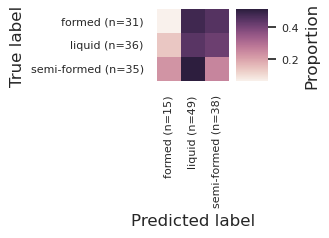

In [91]:
Image(filename=digest / "predictions.png")

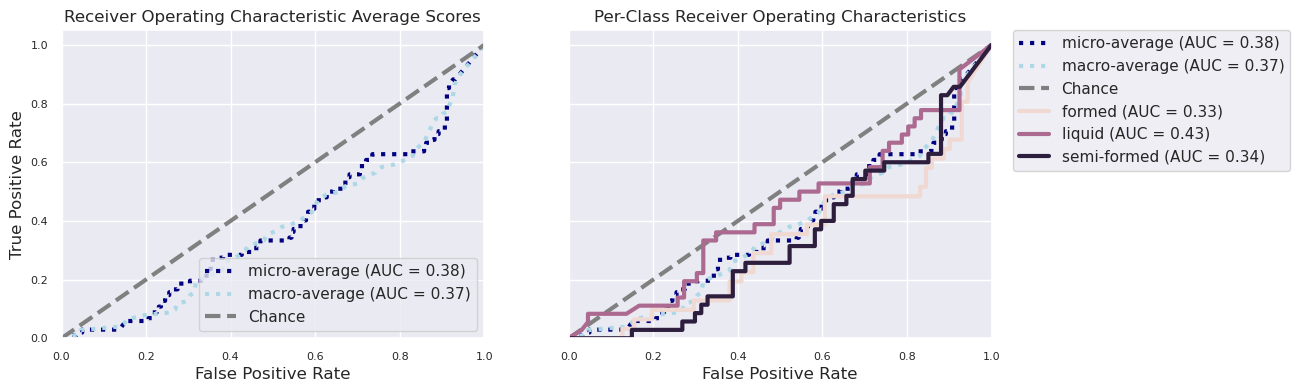

In [92]:
Image(filename=roc)

The ROC curve and AUC score are also horrbile (worse than random guessing)

In [ ]:
!cp $digest/predictive_accuracy.tsv $vis_dir/confusion_matrix_classifier.tsv
!cp $digest/predictions.png $vis_dir/stool_consistency_predictions.png
!cp $digest/roc_plot.png $vis_dir/stool_consistency_roc_plot.png
!rm -r $digest_root

<a id='sec3'></a>  

## 3. Training and evaluating regressors to predict `Recovery_Day`

### 3.2 Training regressor to predict `Recovery_Day` with microbial composition

We use microbiome composition to predict `Recovery_Day` using the `regress-samples` method from `q2-sample-classifier`.

In [121]:
meta_regress = meta[["sample-id", "Stool_Consistency", "Patient_Sex", "Recovery_Day"]].copy()
meta_regress.fillna(-1, inplace=True)
meta_regress.to_csv(mlpred_dir / "metadata_regress.tsv", sep="\t", index=False)

Given our limited sample size we choose the Lasso regression & a RandomForestRegressor.

Training the Lasso regressor:

In [122]:
! qiime sample-classifier regress-samples-ncv \
  --i-table $data_dir/table.qza \
  --m-metadata-file $mlpred_dir/metadata_regress.tsv \
  --m-metadata-column Recovery_Day \
  --p-estimator Lasso \
  --p-random-state 42 \
  --p-n-jobs 16 \
  --p-parameter-tuning \
  --output-dir $mlpred_dir/lasso-regressor

Saved SampleData[RegressorPredictions] to: /home/matchy233/study/alien/data/processed/mlpred/lasso-regressor/predictions.qza
Saved FeatureData[Importance] to: /home/matchy233/study/alien/data/processed/mlpred/lasso-regressor/feature_importance.qza


In [123]:
! qiime sample-classifier scatterplot \
  --i-predictions $mlpred_dir/lasso-regressor/predictions.qza \
  --m-truth-file $mlpred_dir/metadata_regress.tsv \
  --m-truth-column Recovery_Day \
  --o-visualization $mlpred_dir/lasso-regressor/scatter.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/mlpred/lasso-regressor/scatter.qzv


Training the RandomForestRegressor:

In [99]:
! rm -r $mlpred_dir/rf-regressor
! qiime sample-classifier regress-samples-ncv \
  --i-table $data_dir/table.qza \
  --m-metadata-file $data_dir/metadata.tsv \
  --m-metadata-column Recovery_Day \
  --p-n-esimators 100 \
  --p-estimator RandomForestRegressor \
  --p-random-state 42 \
  --p-n-jobs 16 \
  --p-parameter-tuning \
  --output-dir $mlpred_dir/rf-regressor

Saved SampleData[RegressorPredictions] to: /home/matchy233/study/alien/data/processed/mlpred/rf-regressor/predictions.qza
Saved FeatureData[Importance] to: /home/matchy233/study/alien/data/processed/mlpred/rf-regressor/feature_importance.qza


In [102]:
! qiime sample-classifier scatterplot \
  --i-predictions $mlpred_dir/rf-regressor/predictions.qza \
  --m-truth-file $mlpred_dir/metadata_regress.tsv \
  --m-truth-column Recovery_Day \
  --o-visualization $mlpred_dir/rf-regressor/scatter.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/mlpred/rf-regressor/scatter.qzv


### 3.3 Evaluate trained regressor: Accuracy

We visualize the accuracy of regressor via scatter plot. The scatter plot contains a linear regression line fitted to the test data with 95% confidence intervals and a dotted line representing where the predictions of a "perfect" regressor would lie ("perfect" regressor predicting each true value correctly). 

In [139]:
# unzip the confusion matrix qzv file
qza = mlpred_dir / "lasso-regressor" / "scatter.qzv"
a = !unzip -o $qza
digest_root = Path(a[1].split('/')[0].replace("  inflating: ",""))
digest = Path(a[1].split('/')[0].replace("  inflating: ","")) / "data"


In [126]:
stats = pd.read_csv(digest / "predictive_accuracy.tsv", sep="\t")
stats

,Unnamed: 0,Mean squared error,r-value,r-squared,P-value,Std Error,Slope,Intercept
0,Recovery_Day,373.483653,-0.016992,0.000289,0.865394,0.122616,-0.020838,28.671561


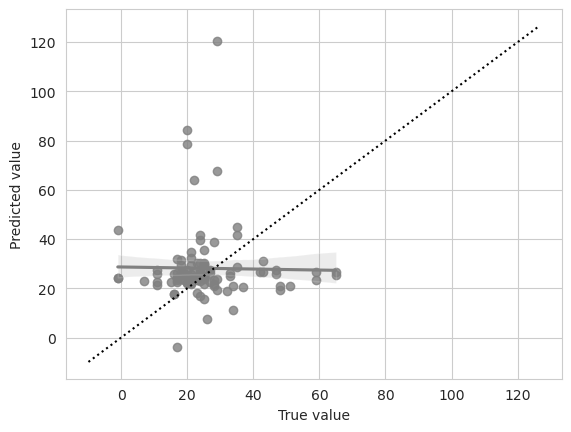

In [127]:
Image(filename=digest / "predictions.png")

In [140]:
digest = str(digest_root)
!cp $digest/predictive_accuracy.tsv $vis_dir/lasso_regressor_stats.tsv
!cp $digest/predictions.png $vis_dir/lasso_regressor_predictions.png
!rm -r $digest_root

In [142]:
# unzip the confusion matrix qzv file
qza = mlpred_dir / "rf-regressor" / "scatter.qzv"
a = !unzip -o $qza
digest_root = Path(a[1].split('/')[0].replace("  inflating: ",""))
digest = Path(a[1].split('/')[0].replace("  inflating: ","")) / "data"

stats = pd.read_csv(digest / "predictive_accuracy.tsv", sep="\t")
stats

,Unnamed: 0,Mean squared error,r-value,r-squared,P-value,Std Error,Slope,Intercept
0,Recovery_Day,148.76243,0.016566,0.000274,0.86874,0.019654,0.003256,24.793614


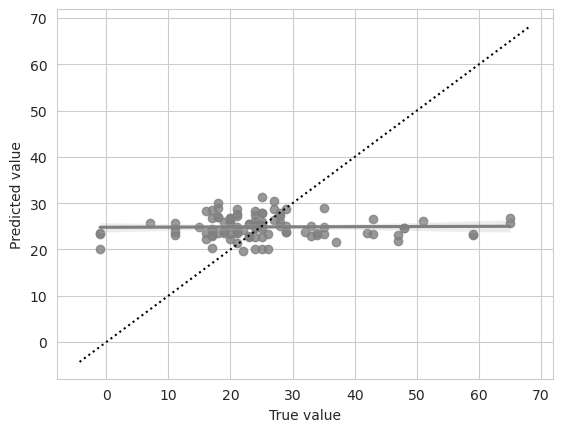

In [129]:
Image(filename=digest / "predictions.png")

In [ ]:
!cp $digest/data/predictive_accuracy.tsv $vis_dir/rf_regressor_stats.tsv
!cp $digest/data/predictions.png $vis_dir/rf_regressor_predictions.png
!rm -r $digest_root

## 4. Conclusion and Extra Analysis

In conclusion, the classifier for predicting stool consistency and the regressor for predicting recovery day are not performing well. This is likely due to the small sample size and the high variability in the data. It is generally useless to check the feature importance of the classifier and regressor, but we can still try to do so for the sake of completeness.

## 4.1 Inspecting feature importance of the classifier

In [150]:
taxa = q2.Artifact.load(data_dir / "taxonomy.qza").view(pd.DataFrame)
taxa.head()

,Taxon,Confidence
Feature ID,,
65c81b7f020fa6530e5995cfadbed4b8,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.995352999769101
3b5167fc05d221e402cb1748506b8442,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9947820597188002
8b03f72e05e140685a739928d4dd2619,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9806855368923134
dc5e130892eb358854eb477a790f8af9,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,0.999971217732479
9b4ec0ce1b21a5a1172c2f0452d9f241,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,0.9999999999999716


In [161]:
# show top 20 most important features for stool consistency prediction
fimp_dir = mlpred_dir / "rf-classifier" / "feature_importance.qza"
feature_importance_stool = q2.Artifact.load(fimp_dir).view(pd.DataFrame)
feature_importance_stool = feature_importance_stool.sort_values("importance", ascending=False)
feature_importance_stool.head(20)

,importance
id,
5d693c96982f3bc9804751b664a0ca4a,0.034295
0aff82fbb663d2be678ad13fcb2050be,0.020964
95126920a496aaf496fa0c4f89e16e5b,0.015710
3c22afdc9d6fd93864c17f7c43e35e4a,0.015360
9a3f5d12656e19e24dccd8ffcce90434,0.013247
6e922fcf27bf74c393e52511c1d475b3,0.013142
e91ab7a717a78f1d068bea7233840ccf,0.011974
6a0b9ccac9e9db70b839805abdfac570,0.010718
e96e7b1c7d4de490dbb32be165504c2e,0.010517


In [154]:
# join the feature importance with the taxonomy to see the taxonomic composition of the most important features
feature_importance_taxa = pd.merge(feature_importance_stool, taxa, left_index=True, right_on="Feature ID")
feature_importance_taxa.head(20)

,importance,Taxon,Confidence
Feature ID,,,
5d693c96982f3bc9804751b664a0ca4a,0.034295,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.9999999999378417
0aff82fbb663d2be678ad13fcb2050be,0.020964,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.981591296928256
95126920a496aaf496fa0c4f89e16e5b,0.015710,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphy...,0.9999999899462466
3c22afdc9d6fd93864c17f7c43e35e4a,0.015360,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9999999380134408
9a3f5d12656e19e24dccd8ffcce90434,0.013247,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.9999999848528144
6e922fcf27bf74c393e52511c1d475b3,0.013142,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.962942067206851
e91ab7a717a78f1d068bea7233840ccf,0.011974,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.9043809880302526
6a0b9ccac9e9db70b839805abdfac570,0.010718,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9043398774393724
e96e7b1c7d4de490dbb32be165504c2e,0.010517,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.9008468306922791


In [157]:
! qiime sample-classifier heatmap \
  --i-table $data_dir/table.qza \
  --i-importance $mlpred_dir/rf-classifier/feature_importance.qza \
  --m-sample-metadata-file $data_dir/metadata.tsv  \
  --m-sample-metadata-column Stool_Consistency \
  --p-group-samples \
  --p-feature-count 20 \
  --o-filtered-table $mlpred_dir/rf-classifier/important-feature-table-top-20.qza \
  --o-heatmap $mlpred_dir/rf-classifier/important-feature-heatmap.qzv

Saved Visualization to: /home/matchy233/study/alien/data/processed/mlpred/rf-classifier/important-feature-heatmap.qzv
Saved FeatureTable[Frequency] to: /home/matchy233/study/alien/data/processed/mlpred/rf-classifier/important-feature-table-top-20.qza


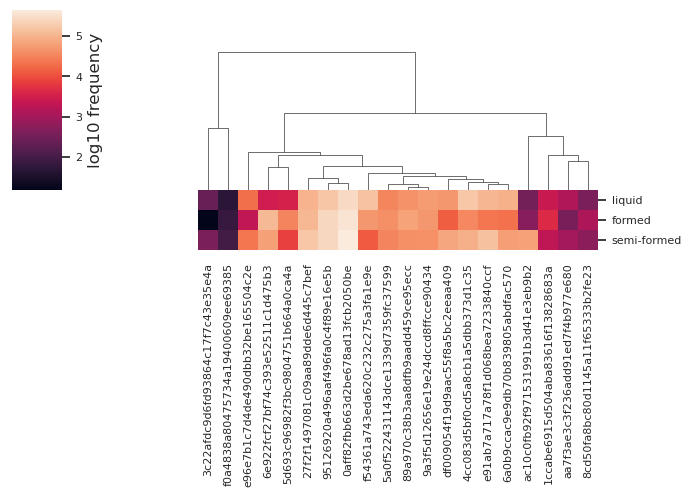

In [ ]:
# visualize the heatmap
heatmap = mlpred_dir / "rf-classifier" / "important-feature-heatmap.qzv"
a = !unzip -o $heatmap
digest_root = Path(a[1].split('/')[0].replace("  inflating: ",""))
digest = Path(a[1].split('/')[0].replace("  inflating: ","")) / "data"

Image(filename=digest / "feature-table-heatmap.png")

In [166]:
! cp $digest/feature-table-heatmap.png $vis_dir/important_feature_heatmap.png
! rm -r $digest_root